# CS146 Problem Set 2: Analytical approximations

**In addition to the LOs indicated below, you will receive an overall grade on #Professionalism.** Please check your work for spelling and grammar, and ensure that the overall layout is clear and easy to read. If you write code, add code comments as needed to explain what the code does.

In this problem set, we revisit the polynomial linear regression models from Session 10. You might find it helpful to revisit the pre-class and breakout workbooks from that class to review the work we did there.

## Overview

We fit polynomials of various degrees to the data set below.

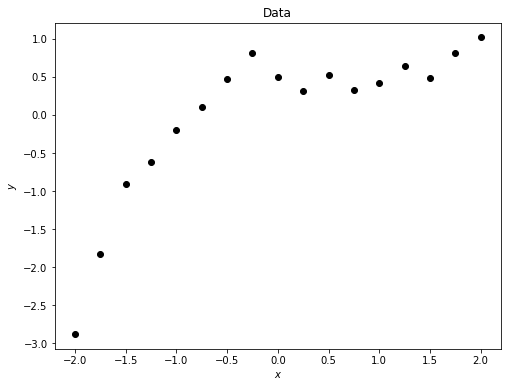

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm


data_x = np.array([
    -2.00, -1.75, -1.50, -1.25, -1.00, -0.75, -0.50, -0.25,
    0.00, 0.25, 0.50, 0.75, 1.00, 1.25, 1.50, 1.75, 2.00])
data_y = np.array([
    -2.878, -1.826, -0.912, -0.617, -0.193, 0.099, 0.475, 0.808,
    0.504, 0.319, 0.524, 0.332, 0.416, 0.638, 0.483, 0.810, 1.017])

plt.figure(figsize=(8, 6))
plt.title('Data')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.plot(data_x, data_y, 'ko')
plt.show()

The polynomial models all have a likelihood function of the form

$$y_i = \text{Normal}(\mu_i, \sigma^2)$$

$$\mu_i = \alpha + \beta_1 x_i + \beta_2 x_i^2 + \cdots + \beta_k x_i^k$$

where $k$ is the degree of the polynomial.

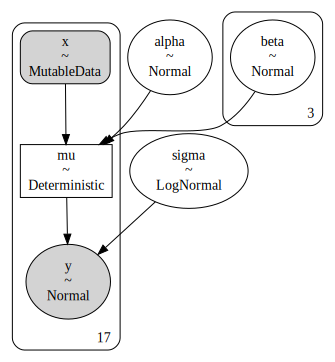

In [2]:
def make_model(degree):
    # Make a polynomial model with the given degree in PyMC
    
    with pm.Model() as model:
        # Data
        x = pm.MutableData('x', data_x)
        # Noise scale
        sigma = pm.LogNormal('sigma', mu=0, sigma=1)
        # Constant term
        alpha = pm.Normal('alpha', mu=0, sigma=1)
        # Coefficients of the x^i terms
        beta = pm.Normal('beta', size=degree, mu=0, sigma=1)
        # Compute the mean of the polynomial given the alpha and beta coefficients
        mu = alpha
        for i in range(1, degree + 1):
            mu = mu + beta[i-1] * x ** i
        mu = pm.Deterministic('mu', mu)
        # Likelihood
        y = pm.Normal('y', mu=mu, sigma=sigma, observed=data_y)
        
    return model

cubic_model = make_model(3)
pm.model_to_graphviz(cubic_model)

## Problem 1: Estimating model evidence (#AnalyticalApproximation)

The goal of the activity in Session 10 was to understand how the _model evidence_ (the denominator in Bayes’ equation, also known as the _marginal likelihood_) helps us to select the best model or models from a collection of models. We used function fitting in PyMC to estimate the model evidence for various polynomial degrees. The code for doing this is provided in Problem 2 below.

Explain why it is possible to use a function fitting algorithm to estimate the model evidence. You may explain this with reference to the function fitting algorithm used in PyMC (ADVI) or with reference to the function fitting algorithm we explored in Sessions 22 and 23 (the Laplace approximation). The answers are somewhat different in those two cases however, you should address the same question in either case — how can we use the algorithm to estimate model evidence?

* Explain why it is possible conceptually.
* Provide the basic mathematical detail for where the model evidence shows up in the function fitting algorithm.
* (You do not actually have to compute the model evidence here. We will do this in Problem 2.)

Without function fitting, it is difficult to calculate the model evidence since this calculation involves integrals. As we increase the number of parameters in the model, the number of integrals also increases linearly. These integrals become too complex to calculate as the number of parameters increases.

The Laplace algorithm finds the peak of the log posterior and matches the peak of the (multivariate) normal to this peak. This means that the modes of both the true posterior and the fitted posterior are the same. The algorithm then matches the covariance of the true posterior with that of the multivariate normal by equivocating the second derivatives of the true log posterior to that of the log multivariate normal PDF. Rearranging, we get that the true log posterior is equal to the negative precision matrix of the multivariate normal. The algorithm thus uses this equation to match the covariance between parameters of the multivariate normal to that in the true posterior.

We are able to calculate an estimation of the model evidence of the Laplace approximation because we fit a (multivariate) normal distribution to the target distribution. Since this distribution is known and has defined formulas for its PDF and CDF, we are able to find the model evidence mathematically by comparing the unnormalised posterior (an unnormalised normal distribution) to a normalised normal distribution: $unnormalised\ fit\ posterior/z=normal\ PDF$. Rearranging this formula, we can obtain the normalisation constant ($z$), the model evidence.

## Problem 2: Was using mean-field a good idea? (#AnalyticalApproximation)

The code below was used to determine the best degree of a polynomial for the data set above. Should it be linear, quadratic, etc.?

In Session 23, we learned that using a mean-field approximation is not necessarily a good idea when fitting a Multivariate Normal to a posterior since it cannot represent correlations between variables. PyMC uses the mean-field approximation by default.

Your task is to analyze the impact of using the mean-field approximation _versus_ the full-rank approximation.

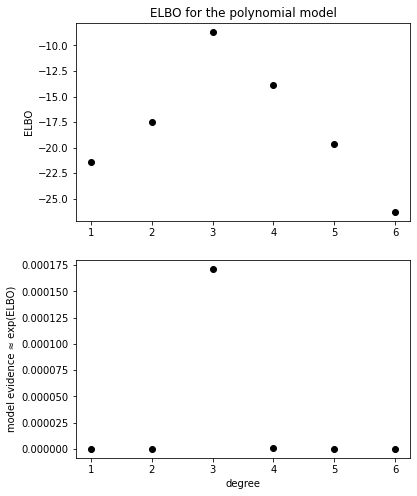

In [3]:
# Store the PyMC models, the function fits (approximations), and estimates
# of the ELBO produced by the function fitting algorithm
models = []
approximations = []
elbos = []

# Create the models and compute the ELBOs for polynomial degrees 1–6
degrees = range(1, 7)
for degree in degrees:
    model = make_model(degree)
    with model:
        approx = pm.fit(100000, progressbar=False)
    models.append(model)
    approximations.append(approx)
    elbos.append(-np.mean(approx.hist[-10000:]))

# Plot the results
plt.figure(figsize=(6, 8))
plt.subplot(2, 1, 1)
plt.title('ELBO for the polynomial model')
plt.plot(degrees, elbos, 'ko')
plt.ylabel('ELBO')
plt.subplot(2, 1, 2)
plt.plot(degrees, np.exp(elbos), 'ko')
plt.xlabel('degree')
plt.ylabel('model evidence ≈ exp(ELBO)')
plt.show()

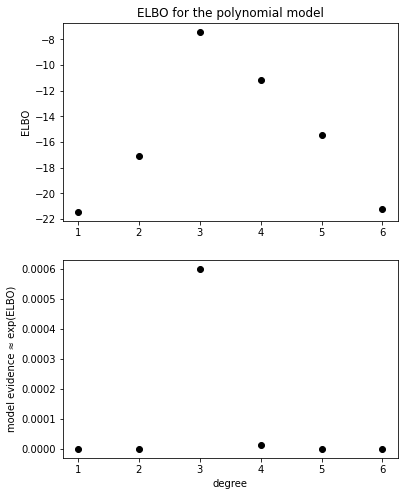

In [4]:
# Store the PyMC models, the function fits (approximations), and estimates
# of the ELBO produced by the function fitting algorithm
models = []
approximations = []
elbos1 = []

# Create the models and compute the ELBOs for polynomial degrees 1–6
degrees = range(1, 7)
for degree in degrees:
    model = make_model(degree)
    with model:
        approx = pm.fit(100000, progressbar=False, method='fullrank_advi')
    models.append(model)
    approximations.append(approx)
    elbos1.append(-np.mean(approx.hist[-10000:]))

# Plot the results
plt.figure(figsize=(6, 8))
plt.subplot(2, 1, 1)
plt.title('ELBO for the polynomial model')
plt.plot(degrees, elbos1, 'ko')
plt.ylabel('ELBO')
plt.subplot(2, 1, 2)
plt.plot(degrees, np.exp(elbos1), 'ko')
plt.xlabel('degree')
plt.ylabel('model evidence ≈ exp(ELBO)')
plt.show()

MF1 : 0.0
MF2 : 0.0
MF3 : 0.2183
MF4 : 0.0012
MF5 : 0.0
MF6 : 0.0
FR1 : 0.0
FR2 : 0.0
FR3 : 0.7628
FR4 : 0.0174
FR5 : 0.0002
FR6 : 0.0


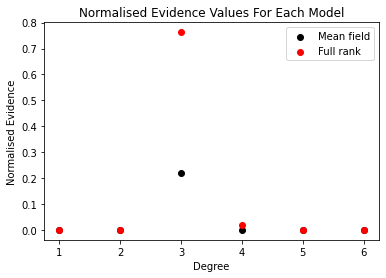

In [5]:
# extract all evidence values
evidence_all = list(np.exp(elbos)) + list(np.exp(elbos1))

models = ['MF1', 'MF2', 'MF3', 'MF4', 'MF5', 'MF6', 'FR1', 'FR2', 'FR3', 'FR4', 'FR5', 'FR6']
norm_evidences = []

# calculate norm evidence values
for i in range(len(evidence_all)):
    norm_evidence = evidence_all[i]/sum(evidence_all)
    norm_evidences.append(norm_evidence)
    print(models[i], ':', round(norm_evidence, 4))

plt.scatter(degrees, norm_evidences[:6], color = 'black', label = 'Mean field')
plt.scatter(degrees, norm_evidences[6:], color = 'red', label = 'Full rank')
plt.title('Normalised Evidence Values For Each Model')
plt.xlabel('Degree')
plt.ylabel('Normalised Evidence')
plt.legend()
plt.show()

Do all of the following.

* Rerun this code using the full-rank ADVI algorithm and record the evidence lower bound (ELBO) values. The ELBO values are approximations of the log of the model evidence.
* How much worse is the mean-field approximation than the full-rank approximation? Quantify your answer to this question and explain your work.
* Do any of our conclusions change about which degrees are better or worse than others?

Mean-field ELBO values: [-21.41439139680245, -17.52198483107041, -8.695464496275243, -13.859030819308444, -19.732021903132992, -26.240898591402296]

Full-rank ELBO values: [-21.422681674686032, -17.123620023181864, -7.421281762968278, -11.201492448860739, -15.463002297850075, -21.242341262941288]

We can quantify the differences between the 12 models by comparing the model evidence for each. This is possible because the model evidence is proportional to the probability of the model:
$P(M|D) = P(D|M)P(M)/P(D)$ where $D$ is the data and $M$ is the model. This holds given that the priors ($P(M)$) for each model are equal. In this case, we assume no prior knowledge about the full-rank and mean-field models, nor about which degree is better. 

We can then calculate the normalised evidence values by dividing the probability of each model by the sum of all probabilities: $P(D|M_i)/Σ_{i=1}^n{P(D|M_i)}$. This gets us more reasonable values that we can then compare.

Our conclusions don't change about which degree is better given the new full-rank models. Degree 3 is the best in both cases. We can divide the normalised evidence values to compare the two models and get the ratio of the probability of the models given the data: $0.7647/0.2167 = 3.53$. Here, we see that the full-rank degree 3 model is $3.53$ times more likely given the data than the mean-field degree 3 model; the mean field approximation for degree 3 is $3.53$ times worse than the full-rank approximation for the same degree. 